<a href="https://colab.research.google.com/github/DimaVlas/CycleGAN-Emotion-Generation/blob/master/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F 

- Function to flatten data

In [0]:
class Flatten(nn.Module):
    def forward(self, _input):
        return _input.view(_input.size(0), -1)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def deconv(c_in, c_out, k_size, stride=2, pad=1, bn=True):
    """Custom deconvolutional layer for simplicity."""
    layers = []
    layers.append(nn.ConvTranspose2d(c_in, c_out, k_size, stride, pad, bias=False))
    if bn:
        layers.append(nn.BatchNorm2d(c_out))
    return nn.Sequential(*layers)

def conv(c_in, c_out, k_size, stride=2, pad=1, bn=True):
    """Custom convolutional layer for simplicity."""
    layers = []
    layers.append(nn.Conv2d(c_in, c_out, k_size, stride, pad, bias=False))
    if bn:
        layers.append(nn.BatchNorm2d(c_out))
    return nn.Sequential(*layers)

# Residual Block. Block has 2 convolution layers


In [0]:
class ResidualBlock(nn.Module):
    def __init__(self, in_ch):
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_ch, in_ch, kernel_size=3, stride=1, padding=1, bias=False)
        self.norm1 = nn.InstanceNorm2d(in_ch)
        self.relu = nn.ReLU()

        self.conv2 = nn.Conv2d(in_ch, in_ch, kernel_size=3, stride=1, padding=1, bias=False)
        self.norm2 = nn.InstanceNorm2d(in_ch)

    def forward(self, x):
        residual = x
        x = self.conv1(x)
        x = self.relu(self.norm1(x))

        x = self.conv2(x)
        x = self.norm2(x)
        x = torch.sigmoid(x)

        return self.relu(residual + x)

# Generator

In [0]:
class Generator(nn.Module):
    def __init__(self, in_ch=1, size_x=48, size_y=48):
        super(Generator, self).__init__()
       
        first_block = [
            nn.Conv2d(in_ch, 64, (7, 7), stride=1, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        ]

        self.first_block = nn.Sequential(*first_block)
        
        # Downsample
        downsample = [
            nn.Conv2d(64, 128, (3, 3), stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        ]
        
        downsample += [
            nn.Conv2d(128, 256, (3, 3), stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        ]
        
        self.downsample = nn.Sequential(*downsample)

        # Residual Blocks

        self.res_blocks = nn.Sequential(
            ResidualBlock(256),
            ResidualBlock(256)
        )

        # Upsample
        upsample = [
            nn.ConvTranspose2d(256, 128, (4, 4), stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        ]
        
        upsample += [
            nn.ConvTranspose2d(128, 64, (4, 4), stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        ]
        
        upsample += [
            nn.Conv2d(64, 1, (7, 7), stride=1, padding=3),
            nn.InstanceNorm2d(1),
            # nn.ReLU()
        ]
        
        self.upsample = nn.Sequential(*upsample)


    def forward(self, x):
        x = self.first_block(x)
        x = self.downsample(x)
        x = self.res_blocks(x)
        x = self.upsample(x)
        x = torch.sigmoid(x)
        return x



# Discrimnator 

In [0]:
class Discriminator(nn.Module):
    def __init__(self, in_ch=1, size_x=48, size_y=48):
        super(Discriminator, self).__init__()
               
        model = [
            nn.Conv2d(in_ch, 64, (4, 4), stride=2, padding=1),
            # torch.nn.BatchNorm2d(num_features, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            nn.BatchNorm2d(64),
            nn.ReLU(),
        ]
        
        size_x = size_x // 2
        size_y = size_y // 2
        
        model += [
            nn.Conv2d(64, 128, (4, 4), stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        ]
        
        size_x = size_x // 2
        size_y = size_y // 2

        model += [
            nn.Conv2d(128, 256, (4, 4), stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        ]
        
        size_x = size_x // 2
        size_y = size_y // 2

        model += [
            nn.Conv2d(256, 512, (4, 4), stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        ]
        
        size_x = size_x // 2
        size_y = size_y // 2

        model += [
            nn.Conv2d(512, 1, (4, 4), stride=2, padding=1),
            nn.ReLU()
        ]
        
        size_x = size_x // 2
        size_y = size_y // 2

        if size_x > 1 or size_y > 1:
            model += [
                Flatten(),
                nn.Linear(size_x * size_y, 1),
                nn.ReLU()
            ]
        
        self.model = nn.Sequential(*model)    


    def forward(self, x):
        return self.model(x)

# Image Utils

In [0]:
class Data:
    def __init__(self, img, psnr=None, time=None, mean=None):
        self.img = img
        self.psnr = psnr
        self.time = time
        self.mean = mean


def matplot_plot_images_dict(data_dict):
    i, columns = 0, len(data_dict)
    scale = columns * 3  # you can play with it
    plt.figure(figsize=(scale, scale))
    for key, data in data_dict.items():
        i, ax = i + 1, plt.subplot(1, columns, i + 1)
        if data.img.ndim == 3:
            if data.img.shape[0] == 1:  # 3D gray image
                tmp_img = data.img[0, :, :]
            else:  # RGB
                tmp_img = np.transpose(data.img, (1, 2, 0))
        else:  # 2D gray image, no changes needed
            tmp_img = data.img
        plt.imshow(tmp_img, cmap='gray')
        ax.text(0.5, -0.3, key + (" psnr: %.2f" % (data.psnr) if data.psnr is not None else ""),
                size=14, ha="center", transform=ax.transAxes)
    plt.show()

# **Image Pool**

In [0]:
import random
import torch


class ImagePool():
    """This class implements an image buffer that stores previously generated images.
    This buffer enables us to update discriminators using a history of generated images
    rather than the ones produced by the latest generators.
    """

    def __init__(self, pool_size):
        """Initialize the ImagePool class
        Parameters:
            pool_size (int) -- the size of image buffer, if pool_size=0, no buffer will be created
        """
        self.pool_size = pool_size
        if self.pool_size > 0:  # create an empty pool
            self.num_imgs = 0
            self.images = []

    def query(self, images):
        """Return an image from the pool.
        Parameters:
            images: the latest generated images from the generator
        Returns images from the buffer.
        By 50/100, the buffer will return input images.
        By 50/100, the buffer will return images previously stored in the buffer,
        and insert the current images to the buffer.
        """
        if self.pool_size == 0:  # if the buffer size is 0, do nothing
            return images
        return_images = []
        for image in images:
            image = torch.unsqueeze(image.data, 0)
            if self.num_imgs < self.pool_size:   # if the buffer is not full; keep inserting current images to the buffer
                self.num_imgs = self.num_imgs + 1
                self.images.append(image)
                return_images.append(image)
            else:
                p = random.uniform(0, 1)
                if p > 0.5:  # by 50% chance, the buffer will return a previously stored image, and insert the current image into the buffer
                    random_id = random.randint(0, self.pool_size - 1)  # randint is inclusive
                    tmp = self.images[random_id].clone()
                    self.images[random_id] = image
                    return_images.append(tmp)
                else:       # by another 50% chance, the buffer will return the current image
                    return_images.append(image)
        return_images = torch.cat(return_images, 0)   # collect all the images and return
        return return_images

# Read data utils

In [0]:
from __future__ import print_function, division

import os
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms as transforms
from PIL import Image
from sklearn.model_selection import train_test_split

In [0]:
def get_params_by_dataset(dataset_name):
    if dataset_name == 'fer2013':
        size_x, size_y = 48, 48
        dataset = FER2013GetEmotion 
        in_ch = 1
        out = 7
    elif dataset_name == 'nova':
        size_x, size_y = 112, 92
        dataset = NovaDataset
        in_ch = 3
        out = 8
    else:
        size_x, size_y = 96, 96
        dataset = CKDataset
        in_ch = 1
        out = 8
    return dataset, in_ch, out, size_x, size_y

In [0]:
def get_train_transform(size_x, size_y, shift=12, rotate=0, scale_min=0.5, scale_max=1.5, shear=0, color_change=1):
    train_transform = transforms.Compose(
        [
            transforms.RandomHorizontalFlip(),
            # transforms.ColorJitter(brightness=color_change, contrast=color_change, saturation=color_change),
            # transforms.RandomCrop((size_x, size_y), padding=shift),
            # transforms.RandomAffine(rotate, scale=[scale_min, scale_max], shear=shear),
            transforms.ToTensor(),
        ])  # dataset training transform
    return train_transform

In [0]:
class FER2013GetEmotion(Dataset):
        """FER2013 dataset."""
        
        def __init__(self, emotion=None, csv_file='fer2013.csv', root_dir='data', usage='Training', transform=None):
            """
            Args:
                csv_file (string): Path to the csv file.
                root_dir (string): Directory with all the images.
                usage is Training or PrivateTest or PublicTest
                transform (callable, optional): Optional transform to be applied
                    on a sample.
            """
            if emotion is None:
                self.emotion = (0, 1)
            self.emotion = emotion
            csv_file = '/content/drive/My Drive/Technion/Semester 12/GAN Project/fer2013.csv'# os.path.join(root_dir, csv_file)
            df = pd.read_csv(csv_file, delimiter=',', header=0)
        
            # Added groupBy
            grouped_df = df.groupby(['emotion'])
            
            grouped_emotion_A = grouped_df.get_group(self.emotion[0])
            grouped_emotion_B = grouped_df.get_group(self.emotion[1])
            
            self.emotion_A_cat = grouped_emotion_A.loc[grouped_emotion_A['Usage'] == usage].copy()
            self.emotion_B_cat = grouped_emotion_B.loc[grouped_emotion_B['Usage'] == usage].copy()
            
            self.transform = transform


        def __len__(self):
            return min(len(self.emotion_A_cat),len(self.emotion_B_cat))

        def __getitem__(self, idx):
            # TODO: random
            row_A = self.emotion_A_cat.iloc[idx]
            face_A = row_A['pixels']
            res_A = [int(i) for i in face_A.split(' ')]
            res_A = np.array(res_A, dtype=np.uint8)
            res_A = np.reshape(res_A, (48, 48))
            im_A = Image.fromarray(res_A, 'L')
            if self.transform:
                im_A = self.transform(im_A)
            
            row_B = self.emotion_B_cat.iloc[idx]
            face_B = row_B['pixels']
            res_B = [int(i) for i in face_B.split(' ')]
            res_B = np.array(res_B, dtype=np.uint8)
            res_B = np.reshape(res_B, (48, 48))
            im_B = Image.fromarray(res_B, 'L')
            if self.transform:
                im_B = self.transform(im_B)
            return {'A': im_A, 'B': im_B,
                    'Label_A': row_A['emotion'],  'Label_B': row_B['emotion']}  # image, label

# Train

In [0]:
if True:
    dtype = torch.cuda.FloatTensor
else:
    dtype = torch.FloatTensor

In [0]:
def torch_to_np(img_var):
    '''Converts an image in torch.Tensor format to np.array.
    From 1 x C x W x H [0..1] to  C x W x H [0..1]
    '''
    return img_var.detach().cpu().numpy()[0]


def np_to_pil(img_np): 
    '''Converts image in np.array format to PIL image.   
    From C x W x H [0..1] to  W x H x C [0...255]
    '''
    ar = np.clip(img_np*255,0,255).astype(np.uint8)  
    if img_np.shape[0] == 1:
        ar = ar[0]
    else:
        ar = ar.transpose(1, 2, 0)
    return Image.fromarray(ar)

In [0]:
def train_runner(netG_A2B, netG_B2A, netD_A, netD_B,
                 out_folder='/content/drive/My Drive/Technion/Semester 12/GAN Project/models_colab', lr_g=0.0002, lr_d=0.0001, n_epochs=100,
                 batchSize=4, dataset_class=None, load=False, image_pool_size=16):
    
    # Optimizers & LR schedulers
    optimizer_G = torch.optim.Adam(itertools.chain(netG_A2B.parameters(), netG_B2A.parameters()),
                                   lr=lr_g, betas=(0.5, 0.999))
    optimizer_D_A = torch.optim.Adam(netD_A.parameters(), lr=lr_d, betas=(0.5, 0.999))
    optimizer_D_B = torch.optim.Adam(netD_B.parameters(), lr=lr_d, betas=(0.5, 0.999))
    
    # folder of the nets:
    netG_A2B_folder = os.path.join(out_folder, 'netG_A2B.pth')
    netG_B2A_folder = os.path.join(out_folder, 'netG_B2A.pth')
    netD_A_folder = os.path.join(out_folder, 'netD_A.pth')
    netD_B_folder = os.path.join(out_folder, 'netD_B.pth')
    epoch_number_folder = os.path.join(out_folder, 'epoch.txt')
    optimizers_folder = os.path.join(out_folder, 'optimizer.pth')
            
    # load?
    epoch = 0
    if load:
        # Load state dicts
        if os.path.exists(optimizers_folder):
          optimizer_G.load_state_dict(torch.load(optimizers_folder)['optimizer_G_state_dict'])
          optimizer_D_A.load_state_dict(torch.load(optimizers_folder)['optimizer_D_A_state_dict'])
          optimizer_D_B.load_state_dict(torch.load(optimizers_folder)['optimizer_D_B_state_dict'])
          
        netG_A2B.load_state_dict(torch.load(netG_A2B_folder))
        netG_B2A.load_state_dict(torch.load(netG_B2A_folder))
        netD_A.load_state_dict(torch.load(netD_A_folder))
        netD_B.load_state_dict(torch.load(netD_B_folder))
        with open(epoch_number_folder) as file:
            epoch = int(file.read())
        n_epochs += epoch
        # read first line
        print("Loaded successfully")

    
    fake_A_pool = ImagePool(image_pool_size)  # create image buffer to store previously generated images
    fake_B_pool = ImagePool(image_pool_size)  # create image buffer to store previously generated images
    
    
    # Lossess
    criterion_GAN = torch.nn.MSELoss()
    criterion_cycle = torch.nn.L1Loss()

    # Read data
    # Inputs & targets memory allocation
    target_real = torch.ones([batchSize, 1, 1, 1]).type(dtype)
    target_fake = torch.zeros([batchSize, 1, 1, 1]).type(dtype)

    # Dataset loader
    dataset_name = 'fer2013'
    
    dataset, in_ch, out, size_x, size_y = get_params_by_dataset(dataset_name)   
    
    # Dtata loader with 3 - happy, 4 - sad datasets
    dataloader = DataLoader(dataset(emotion=(3, 4), transform=get_train_transform(size_x, size_y)),
                            batch_size=batchSize, shuffle=True)


    # -------- Training -------- #
    for epoch in range(epoch, n_epochs):
        first = True
        print("------------------------  epoch {} --------------------------".format(epoch))
        for batch in dataloader:
           
            # Set model input
            # Get real items of domains A,B
            real_A = batch['A'].type(dtype)
            real_B = batch['B'].type(dtype)
            
            # ------ Generators A2B and B2A ------ #
            optimizer_G.zero_grad()

            # GAN loss
            fake_B = netG_A2B(real_A) #G_A(A)
            # GAN loss D_A(G_A(A))
            if (fake_B.shape[0] != 4):
                continue
            loss_GAN_A2B = criterion_GAN(netD_A(fake_B), target_real)

            fake_A = netG_B2A(real_B) #G_B(B)
            # GAN loss D_B(G_B(B))
            loss_GAN_B2A = criterion_GAN(netD_B(fake_A), target_real)

            # Cycle loss
            
            # Forward cycle loss || G_B(G_A(A)) - A||
            recovered_A = netG_B2A(fake_B) # G_B(G_A(A))
            loss_cycle_ABA = criterion_cycle(recovered_A, real_A) * 10.0

            # Backward cycle loss || G_A(G_B(B)) - B||
            recovered_B = netG_A2B(fake_A) # G_A(G_B(B))
            loss_cycle_BAB = criterion_cycle(recovered_B, real_B) * 10.0

            # Total loss
            loss_G = loss_GAN_A2B + loss_GAN_B2A + loss_cycle_ABA + loss_cycle_BAB
            loss_G.backward()

            optimizer_G.step()
            ###################################
            
            # Print images
            if first == True:
              first = False
              images_dict = {
                  'Real Happy': Data(torch_to_np(real_A)),
                  'Fake Sad': Data(torch_to_np(fake_B)),
                  'Recovered Happy': Data(torch_to_np(recovered_A)),
              }
              matplot_plot_images_dict(images_dict)

              images_dict = {
                  'Real Sad': Data(torch_to_np(real_B)),
                  'Fake Happy': Data(torch_to_np(fake_A)),
                  'Recovered Sad': Data(torch_to_np(recovered_B)),
              }

              matplot_plot_images_dict(images_dict)
            
            # if first == True:
            #    print('\nPRINT IMAGE\nFake Happy')
            #    first = False
            #    plt.imshow(np_to_pil(torch_to_np(fake_A)), cmap='gray')
            #    plt.show()
            #    print('\nReal Sad')
            #    plt.imshow(np_to_pil(torch_to_np(real_B)), cmap='gray')
            #    plt.show()
            #    print('\nPRINT IMAGE\nFake Sad')
            #   first = False
            #   plt.imshow(np_to_pil(torch_to_np(fake_B)), cmap='gray')
            #    plt.show()
            #   print('\nReal Happy')
            #   plt.imshow(np_to_pil(torch_to_np(real_A)), cmap='gray')
            #   plt.show()
            
            ###################################

            # ------ Discriminator A ------ #
            optimizer_D_A.zero_grad()

            # Real_B loss 1
            loss_D_real = criterion_GAN(netD_A(real_B), target_real)
            
            # Fake_B loss 0
            fake_B = fake_B_pool.query(fake_B)
            loss_D_fake = criterion_GAN(netD_A(fake_B.detach()), target_fake)
            
            # Real_B loss 0
            # pred_real_B = netD_A(real_B)
            # loss_D_real_B = criterion_cycle(pred_real_A, target_fake)

            # Total loss
            loss_D_A = (loss_D_real + loss_D_fake) * (0.5)
            loss_D_A.backward()

            optimizer_D_A.step()
            ###################################

            # ------ Discriminator B ------ #
            optimizer_D_B.zero_grad()

            # Real_B loss 1
            loss_D_real = criterion_GAN(netD_B(real_A), target_real)
            
            # Fake loss
            fake_A = fake_A_pool.query(fake_A)
            loss_D_fake = criterion_GAN(netD_B(fake_A.detach()), target_fake)
            
            # Real_A loss 0
            # pred_real_A = netD_B(real_A)
            # loss_D_real_A = criterion_cycle(pred_real_A, target_fake)


            # Total loss
            loss_D_B = (loss_D_real + loss_D_fake) * (0.5)
            loss_D_B.backward()

            optimizer_D_B.step()
            ###################################
            
                
            print('\rloss_G: {0}, loss_G_GAN: {1}, loss_G_cycle: {2}, loss_D: {3}'.format(loss_G,
                                                                                        (loss_GAN_A2B + loss_GAN_B2A),
                                                                                        (loss_cycle_ABA + loss_cycle_BAB),
                                                                                        (loss_D_A + loss_D_B))
                 , end='')


        # Save models checkpoints
        
        torch.save({
            'optimizer_G_state_dict': optimizer_G.state_dict(),
            'optimizer_D_A_state_dict': optimizer_D_A.state_dict(),
            'optimizer_D_B_state_dict': optimizer_D_B.state_dict()
            }, optimizers_folder)
        torch.save(netG_A2B.state_dict(), netG_A2B_folder)
        torch.save(netG_B2A.state_dict(), netG_B2A_folder)
        torch.save(netD_A.state_dict(), netD_A_folder, )
        torch.save(netD_B.state_dict(), netD_B_folder)
        with open(epoch_number_folder, 'w+') as file:
            file.write(str(epoch + 1))
        print("\nSAVED\n")



STARTED TRAINING

------------------------  epoch 0 --------------------------


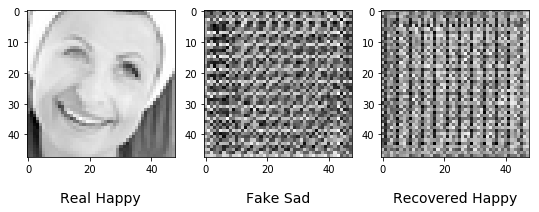

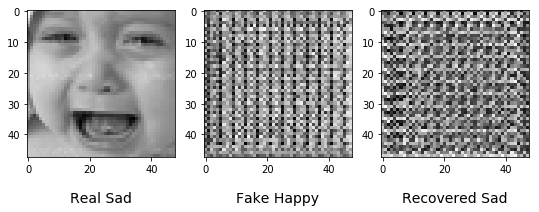

loss_G: 3.9739646911621094, loss_G_GAN: 1.3754308223724365, loss_G_cycle: 2.5985336303710938, loss_D: 0.0687427669763565
SAVED

------------------------  epoch 1 --------------------------


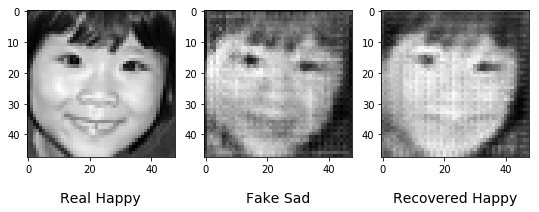

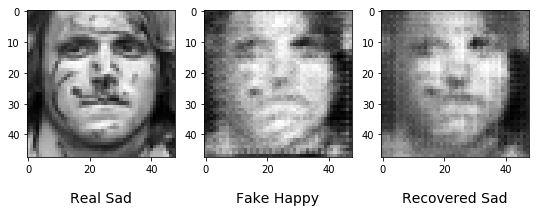

loss_G: 4.19024658203125, loss_G_GAN: 1.4438130855560303, loss_G_cycle: 2.7464332580566406, loss_D: 0.09875054657459259
SAVED

------------------------  epoch 2 --------------------------


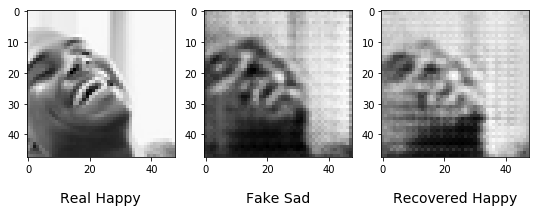

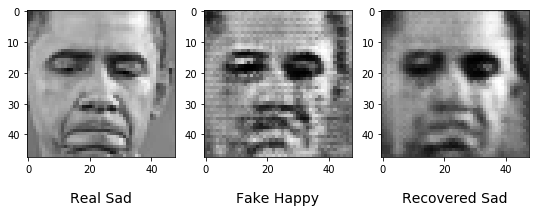

loss_G: 3.6376590728759766, loss_G_GAN: 1.9599509239196777, loss_G_cycle: 1.6777081489562988, loss_D: 0.17225804924964905
SAVED

------------------------  epoch 3 --------------------------


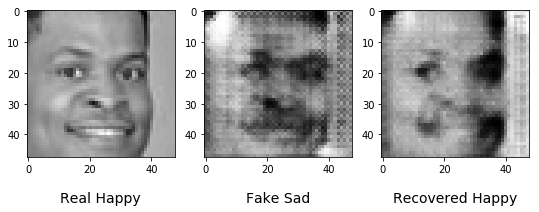

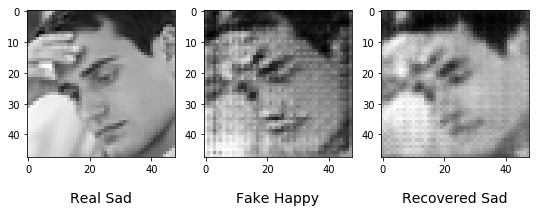

loss_G: 3.634375810623169, loss_G_GAN: 1.6284393072128296, loss_G_cycle: 2.00593638420105, loss_D: 0.021611357107758522
SAVED

------------------------  epoch 4 --------------------------


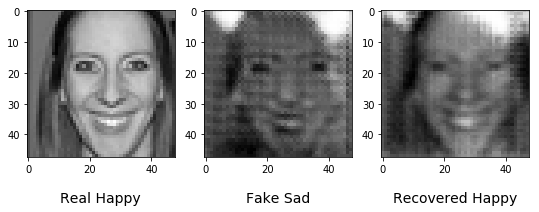

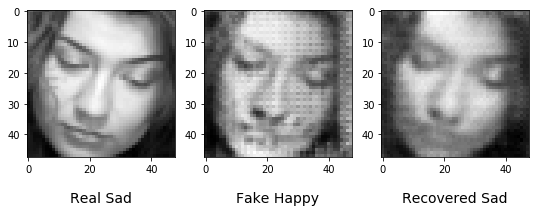

loss_G: 4.575380802154541, loss_G_GAN: 1.8697415590286255, loss_G_cycle: 2.705639362335205, loss_D: 0.041069094091653824
SAVED

------------------------  epoch 5 --------------------------


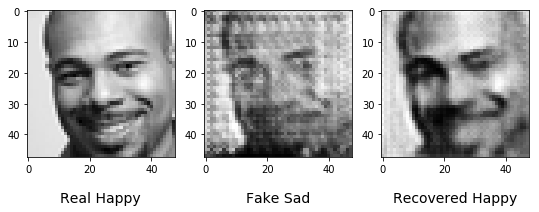

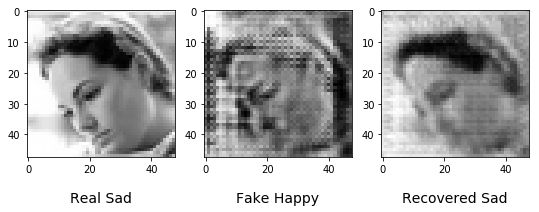

loss_G: 4.374349117279053, loss_G_GAN: 1.860032320022583, loss_G_cycle: 2.5143165588378906, loss_D: 0.04427572339773178
SAVED

------------------------  epoch 6 --------------------------


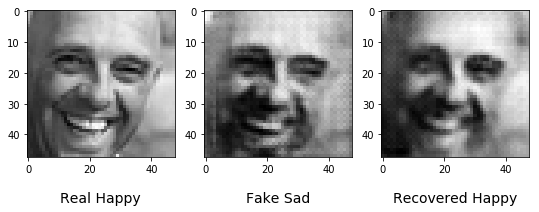

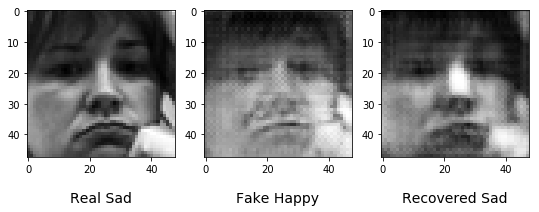

loss_G: 4.299263954162598, loss_G_GAN: 1.8933947086334229, loss_G_cycle: 2.4058690071105957, loss_D: 0.016580291092395782

In [0]:
netG_A2B = Generator().type(dtype)
netG_B2A = Generator().type(dtype)
netD_A = Discriminator().type(dtype)
netD_B = Discriminator().type(dtype)
print("\nSTARTED TRAINING\n")
train_runner(netG_A2B, netG_B2A, netD_A, netD_B, load=True)